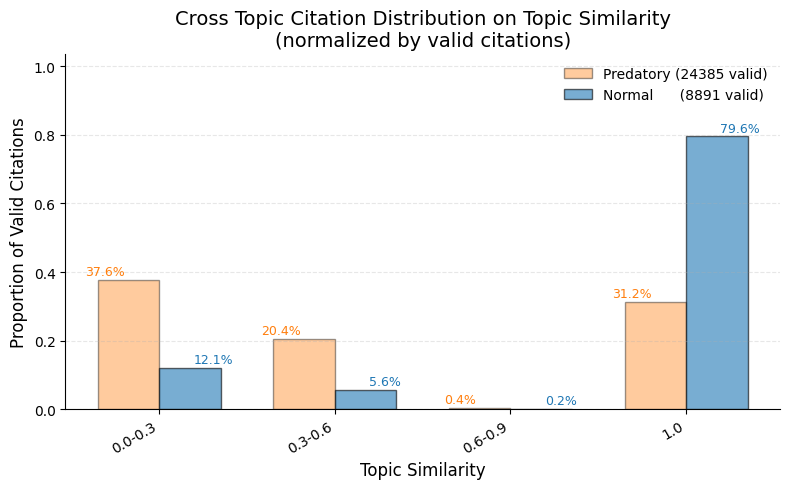

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_topic_map(topic_csv, id_col='id', topic_col='topic_title_abs_30'):
    df = pd.read_csv(topic_csv, usecols=[id_col, topic_col])
    df[id_col]    = pd.to_numeric(df[id_col], errors='coerce')
    df[topic_col] = pd.to_numeric(df[topic_col], errors='coerce')
    df.loc[df[topic_col] == -1, topic_col] = np.nan
    df = df.dropna(subset=[id_col, topic_col])
    df[id_col]    = df[id_col].astype(int)
    df[topic_col] = df[topic_col].astype(int)
    return dict(zip(df[id_col], df[topic_col]))


def gather_similarities(edge_list_file, topic_map, sim_matrix):
   
    sim_all = []
    total_count = 0
    missing_count = 0

    with open(edge_list_file) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2 or not parts[0].isdigit() or not parts[1].isdigit():
                continue
            total_count += 1
            src, dst = map(int, parts)
            t_src = topic_map.get(src)
            t_dst = topic_map.get(dst)
            if t_src is None or t_dst is None:
                missing_count += 1
                continue
            sim_all.append(1.0 if t_src == t_dst else sim_matrix.at[t_src, t_dst])

    return np.array(sim_all), total_count, missing_count

sim_path       = 'data/similarity_matrix_30_abs_clean.csv'
good_topic_csv = 'data/norm/dataset/csv/papers.csv'
good_edges     = 'data/norm/metadata/edge_list.txt'
bad_topic_csv  = 'data/pred/dataset/csv/papers.csv'
bad_edges      = 'data/pred/metadata/edge_list.txt'

# 1. Load maps and similarity matrix
topic_map_g = load_topic_map(good_topic_csv)
topic_map_b = load_topic_map(bad_topic_csv)

sim_df = pd.read_csv(sim_path, index_col=0)
sim_df.index   = sim_df.index.astype(int)
sim_df.columns = sim_df.columns.astype(int)

sim_all_g, total_g, miss_g = gather_similarities(good_edges, topic_map_g, sim_df)
sim_all_b, total_b, miss_b = gather_similarities(bad_edges,  topic_map_b, sim_df)

valid_g = total_g - miss_g
valid_b = total_b - miss_b

bins = np.array([0.0, 0.3, 0.6, 0.9, 1.0])
counts_g, _ = np.histogram(sim_all_g, bins=bins)
counts_b, _ = np.histogram(sim_all_b, bins=bins)

prop_g = counts_g / valid_g
prop_b = counts_b / valid_b

fig, ax = plt.subplots(figsize=(8, 5))

labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}' for i in range(len(bins)-2)] + ['1.0']
x = np.arange(len(labels))
width = 0.35

vals_b = prop_b
vals_g = prop_g

ax.bar(x - width/2, vals_b, width,
       label=f'Predatory ({valid_b} valid)', color='#ff7f0e', alpha=0.4, edgecolor='black')
ax.bar(x + width/2, vals_g, width,
       label=f'Normal      ({valid_g} valid)', color='#1f77b4', alpha=0.6, edgecolor='black')

offset = 0.02
for xi, vb, vg in zip(x, vals_b, vals_g):
    if vb > 0:
        ax.text(xi - width/2 - offset, vb + 0.005,
                f'{vb*100:.1f}%', ha='right', va='bottom',
                color='#ff7f0e', fontsize=9)
    if vg > 0:
        ax.text(xi + width/2 + offset, vg + 0.005,
                f'{vg*100:.1f}%', ha='left', va='bottom',
                color='#1f77b4', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.set_xlabel('Topic Similarity', fontsize=12)
ax.set_ylabel('Proportion of Valid Citations', fontsize=12)
ax.set_title('Cross Topic Citation Distribution on Topic Similarity\n(normalized by valid citations)', fontsize=14)
ax.set_ylim(0, max(vals_b.max(), vals_g.max()) * 1.3)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend(loc='upper right', frameon=False, fontsize=10)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

cross_b = counts_b[:-1].sum()
cross_g = counts_g[:-1].sum()

prop_cross_b = cross_b / valid_b
prop_cross_g = cross_g / valid_g

count = np.array([cross_b, cross_g])
nobs  = np.array([valid_b, valid_g])

stat, pval = proportions_ztest(count, nobs, alternative='two-sided')
diff = prop_cross_b - prop_cross_g

n_b = valid_b
n_g = valid_g

p_b = cross_b / n_b
p_g = cross_g / n_g

stat, pval = proportions_ztest([cross_b, cross_g], [n_b, n_g], alternative='two-sided')

h = 2 * (np.arcsin(np.sqrt(p_b)) - np.arcsin(np.sqrt(p_g)))

print(f"Predatory cross-topic citation: {cross_b}/{n_b} = {p_b:.3%}")
print(f"Normal      cross-topic citation: {cross_g}/{n_g} = {p_g:.3%}")
print(f"\nTwo-proportion z-test: z = {stat:.3f}, p = {pval:.3e}")
print(f"Cohen’s h = {h:.3f}")


Predatory cross-topic citation: 14252/24385 = 58.446%
Normal      cross-topic citation: 1583/8891 = 17.805%

Two-proportion z-test: z = 65.686, p = 0.000e+00
Cohen’s h = 0.869
